In [3]:
!pip install pandas numpy matplotlib seaborn ucimlrepo --q

In [24]:
## Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [12]:
statlog_german_credit_data = fetch_ucirepo(id=144)

#extracting features
aX = statlog_german_credit_data.data.features.copy()
ay = statlog_german_credit_data.data.targets.copy()


In [14]:
# Display metadata and variables information
print(statlog_german_credit_data.metadata)


{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [15]:
print(statlog_german_credit_data.variables)


           name     role         type     demographic  \
0    Attribute1  Feature  Categorical            None   
1    Attribute2  Feature      Integer            None   
2    Attribute3  Feature  Categorical            None   
3    Attribute4  Feature  Categorical            None   
4    Attribute5  Feature      Integer            None   
5    Attribute6  Feature  Categorical            None   
6    Attribute7  Feature  Categorical           Other   
7    Attribute8  Feature      Integer            None   
8    Attribute9  Feature  Categorical  Marital Status   
9   Attribute10  Feature  Categorical            None   
10  Attribute11  Feature      Integer            None   
11  Attribute12  Feature  Categorical            None   
12  Attribute13  Feature      Integer             Age   
13  Attribute14  Feature  Categorical            None   
14  Attribute15  Feature  Categorical           Other   
15  Attribute16  Feature      Integer            None   
16  Attribute17  Feature  Categ

In [16]:
# overview of the data
print(aX.head())
print(ay.head())


  Attribute1  Attribute2 Attribute3 Attribute4  Attribute5 Attribute6  \
0        A11           6        A34        A43        1169        A65   
1        A12          48        A32        A43        5951        A61   
2        A14          12        A34        A46        2096        A61   
3        A11          42        A32        A42        7882        A61   
4        A11          24        A33        A40        4870        A61   

  Attribute7  Attribute8 Attribute9 Attribute10  Attribute11 Attribute12  \
0        A75           4        A93        A101            4        A121   
1        A73           2        A92        A101            2        A121   
2        A74           2        A93        A101            3        A121   
3        A74           2        A93        A103            4        A122   
4        A73           3        A93        A101            4        A124   

   Attribute13 Attribute14 Attribute15  Attribute16 Attribute17  Attribute18  \
0           67        A1

In [20]:
# shape of the dataset
print("Shape of X:", aX.shape)
print("Shape of y:", ay.shape)



Shape of X: (1000, 20)
Shape of y: (1000, 1)


Target distribution: class
1    700
2    300
Name: count, dtype: int64


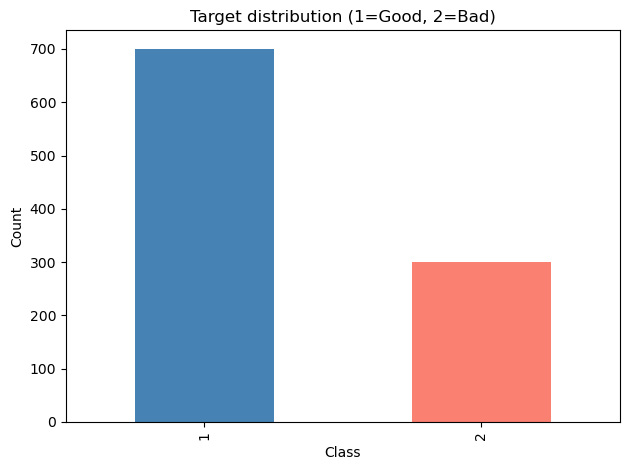

In [21]:
print("Target distribution:", ay['class'].value_counts())

ay['class'].value_counts().plot(kind='bar', color=['steelblue', 'salmon'])
plt.title('Target distribution (1=Good, 2=Bad)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [26]:
#  numeric and categorical columns
a_num_cols = aX.select_dtypes(include=['int64', 'float64']).columns.tolist()
a_cat_cols = aX.select_dtypes(include='object').columns.tolist()
print(a_num_cols)
print(a_cat_cols)

['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20']


In [27]:
print("Numeric columns:",len(a_num_cols))
print("Categorical columns:", len(a_cat_cols))

Numeric columns: 7
Categorical columns: 13


In [28]:
numeric_desc = aX[a_num_cols].describe()
print(numeric_desc)


        Attribute2    Attribute5   Attribute8  Attribute11  Attribute13  \
count  1000.000000   1000.000000  1000.000000  1000.000000  1000.000000   
mean     20.903000   3271.258000     2.973000     2.845000    35.546000   
std      12.058814   2822.736876     1.118715     1.103718    11.375469   
min       4.000000    250.000000     1.000000     1.000000    19.000000   
25%      12.000000   1365.500000     2.000000     2.000000    27.000000   
50%      18.000000   2319.500000     3.000000     3.000000    33.000000   
75%      24.000000   3972.250000     4.000000     4.000000    42.000000   
max      72.000000  18424.000000     4.000000     4.000000    75.000000   

       Attribute16  Attribute18  
count  1000.000000  1000.000000  
mean      1.407000     1.155000  
std       0.577654     0.362086  
min       1.000000     1.000000  
25%       1.000000     1.000000  
50%       1.000000     1.000000  
75%       2.000000     1.000000  
max       4.000000     2.000000  


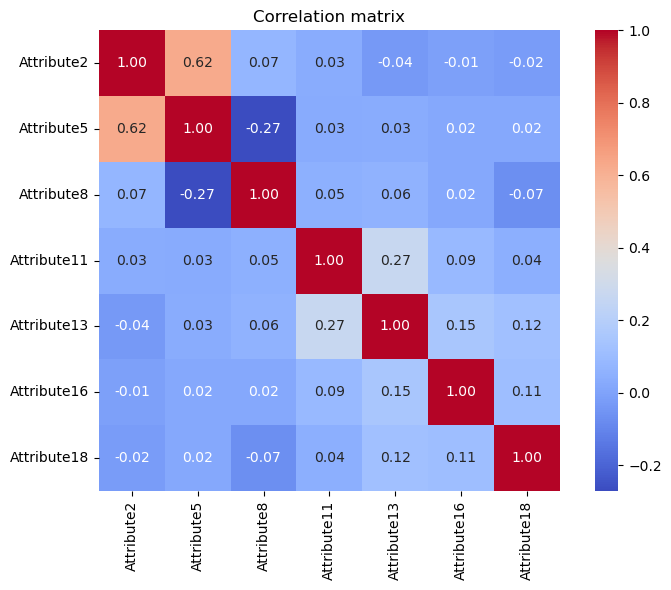

In [29]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(8,6))
cor = aX[a_num_cols].corr()
sns.heatmap(cor, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

In [31]:
# creating preprocessing pipeline

#  impute (though none missing) + one-hot for categoricals

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocess = ColumnTransformer([
    ('num', numeric_pipeline, a_num_cols),
    ('cat', categorical_pipeline, a_cat_cols)
])

In [33]:
# splitting the dataset

X_train, X_test, y_train, y_test = train_test_split(aX, ay['class'], test_size=0.2, random_state=42, stratify=ay['class'])


In [36]:
X_train.shape


(800, 20)

In [37]:
y_train.shape

(800,)

In [38]:
# random forest model

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
pipe = Pipeline([
    ('pre', preprocess),
    ('rf', rf_model)
])


In [39]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Attribute2', 'Attribute5',
                                                   'Attribute8', 'Attribute11',
                                                   'Attribute13', 'Attribute16',
                                                   'Attribute18']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Attribute1', 'Attribute3',
                                                   'Attribute4', 'Attribute6',
                                                   'Attribute7', 'Attribute9',
                                                   'Attribute10', 'Attribute12',
                                                   'Attribute14', 'Attribute15',
                                                   'Attribute17', 'Attribute19',
                                                   'Attribute20'])])),
                ('rf',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

In [40]:
# Evaluations

preds = pipe.predict(X_test)
probs = pipe.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs)
print("Accuracy:", acc)
print("AUROC:", auc)

Accuracy: 0.77
AUROC: 0.7907738095238095


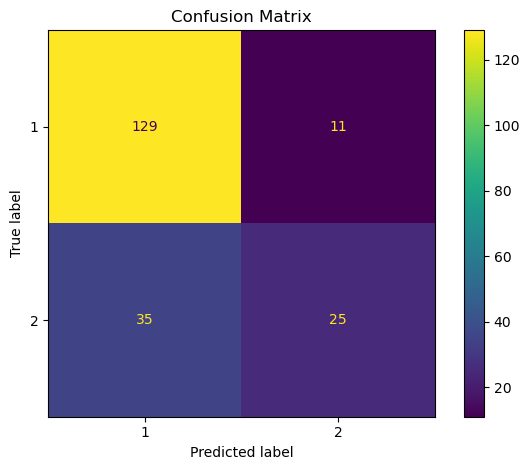

In [41]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [42]:
# Feature Engineering
# (aggregate one-hot back) – get ohe feature names
ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
feature_names = a_num_cols + ohe.get_feature_names_out(a_cat_cols).tolist()
importances = pipe.named_steps['rf'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)
print("Top 15 feature importances:", fi)

Top 15 feature importances: Attribute5          0.097920
Attribute2          0.076284
Attribute13         0.075409
Attribute1_A14      0.050763
Attribute1_A11      0.036112
Attribute8          0.034966
Attribute11         0.032875
Attribute6_A61      0.021181
Attribute3_A34      0.020736
Attribute7_A72      0.018800
Attribute1_A12      0.018245
Attribute16         0.017891
Attribute14_A143    0.016553
Attribute12_A121    0.016478
Attribute4_A40      0.016355
dtype: float64


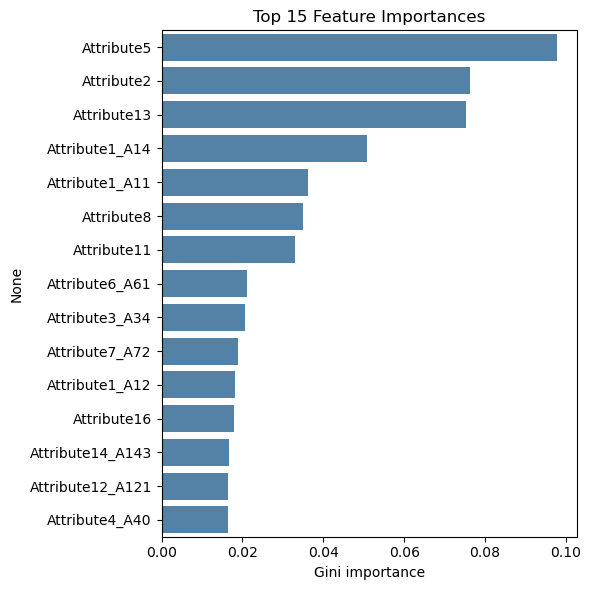

In [43]:
plt.figure(figsize=(6,6))
sns.barplot(x=fi.values, y=fi.index, orient='h', color='steelblue')
plt.title('Top 15 Feature Importances')
plt.xlabel('Gini importance')
plt.tight_layout()
plt.show()